## Load libraries

In [1]:
from __future__ import division, unicode_literals, print_function

import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

mpl.rc('figure', figsize=(20, 20))
mpl.rc('image', cmap = "gray")

import numpy as np
import pandas as pd
from pandas import DataFrame, Series

import pims
import trackpy as tp

from omero.gateway import BlitzGateway
from omero.model import PointI, PolylineI, RoiI
from omero.rtypes import rdouble, rint, rstring

from getpass import getpass


#some wells have problems with track linking; increasing sub_net_size helped
tp.linking.Linker.MAX_SUB_NET_SIZE=150

### OMERO Credentials

In [2]:
HOST = 'wss://outreach.openmicroscopy.org/omero-ws'
conn = BlitzGateway(input("Username: "),
                    getpass("OMERO Password: "),
                    host=HOST, secure=True)
print(conn.connect())
conn.c.enableKeepAlive(60)

Username: trainer-1
OMERO Password: ········
True


### Fetch OMERO Image to be analysed

In [3]:
image_id = 58622
image = conn.getObject("Image", image_id)
print('Image Name: ', image.getName())

Image Name:  NPSCDD0000561_20180607_025332_A01.pattern


## Read the image and convert it into pims frames

In [4]:
def load_frames(image):
    pixels = image.getPrimaryPixels()
    size_z = image.getSizeZ()
    size_c = image.getSizeC()
    size_t = image.getSizeT()
    size_y = image.getSizeY()
    size_x = image.getSizeX()
    z, t, c = 0, 0, 0  # first plane of the image

    zct_list = []
    for t in range(size_t):
        for z in range(size_z):  # get the Z-stack
            for c in range(size_c):  # all channels
                zct_list.append((z, c, t))

    values = []
    # Load all the planes as YX numpy array
    planes = pixels.getPlanes(zct_list)
    s = "z:%s t:%s c:%s y:%s x:%s" % (size_z, size_t, size_c, size_y, size_x)
    print(s)
    # axis tzyxc
    print("Downloading image %s" % image.getName())
    frames = []
    for i, p in enumerate(planes):
        f = pims.frame.Frame(p, frame_no=i)
        frames.append(f)

    return frames

In [5]:
frames = load_frames(image)

z:1 t:23 c:1 y:720 x:853


Frame([[4255, 4285, 4347, ..., 3556, 3582, 3660],
       [4225, 4060, 4324, ..., 3514, 3409, 3664],
       [4186, 4265, 3984, ..., 3382, 3421, 3670],
       ...,
       [4346, 4352, 4347, ..., 3476, 3464, 3671],
       [4173, 4197, 4200, ..., 3309, 3520, 3433],
       [4352, 4339, 4357, ..., 3728, 3567, 3665]], dtype=uint16)
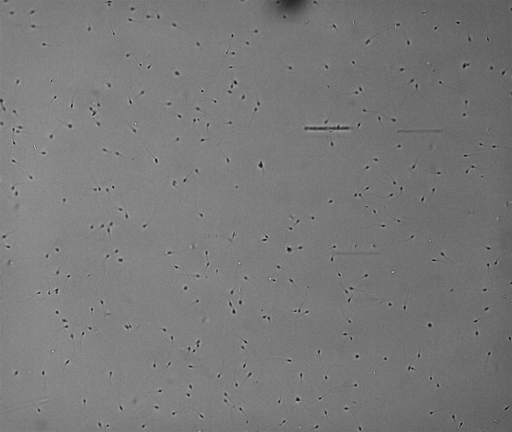

In [6]:
frames[1]

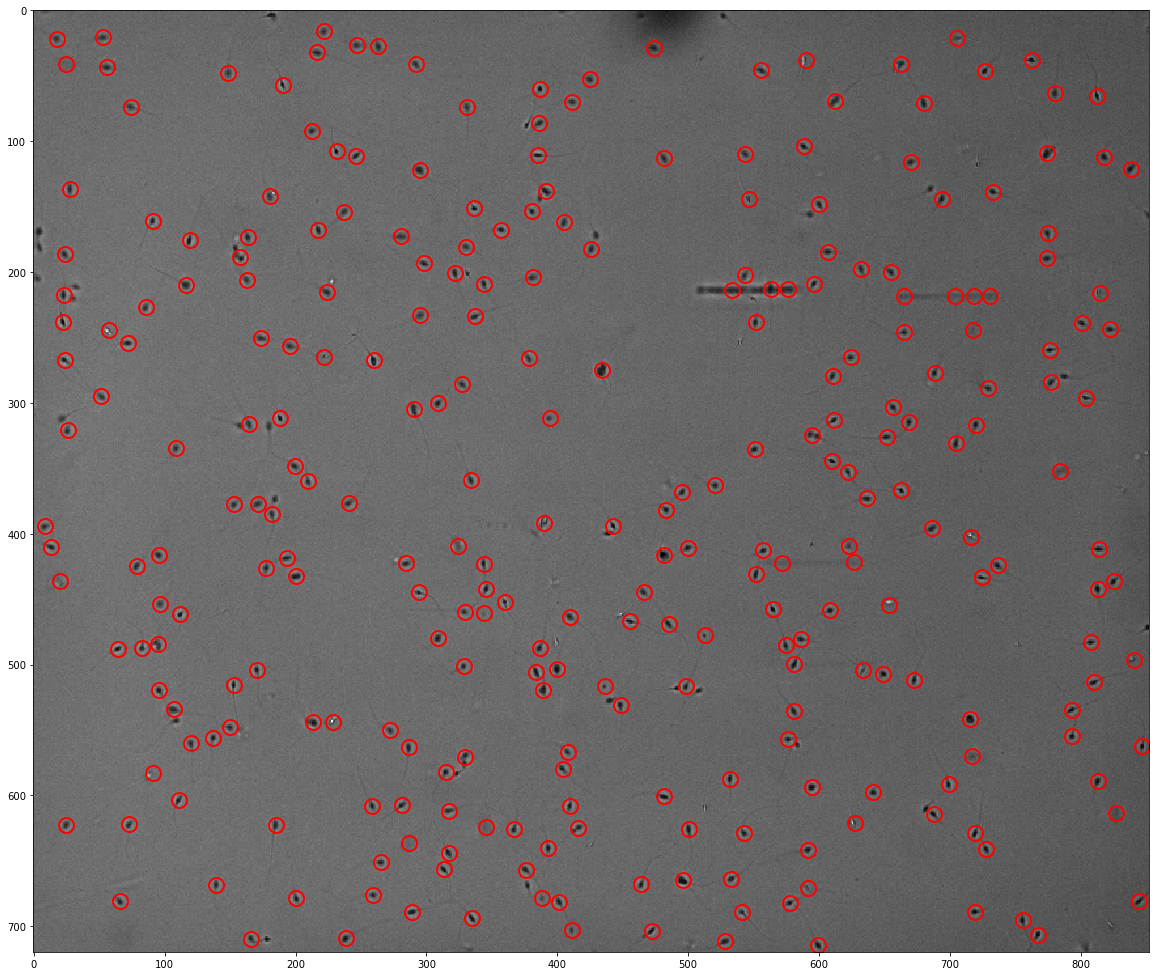

<AxesSubplot:>

In [7]:
#locate sperm cells
sc_loc = tp.locate(frames[0], diameter=11, invert=True, minmass = 4000)

#visual check
plt.figure()
tp.annotate(sc_loc, frames[0])

In [8]:
particles = tp.batch(frames, diameter = 11, minmass = 4000, invert = True)

Frame 22: 302 features


In [9]:
#track filtering; values based on several bad wells encountered over years
temp_particles = particles[(particles.signal > 950) & (particles['size'] < 2.5)]


if len(temp_particles) < 150:
    particles = particles[(particles.signal > 550) & (particles['size'] < 2.5)]
else:
    particles = temp_particles


## Visualize effect of filtering. Some detected blobs are now being removed.

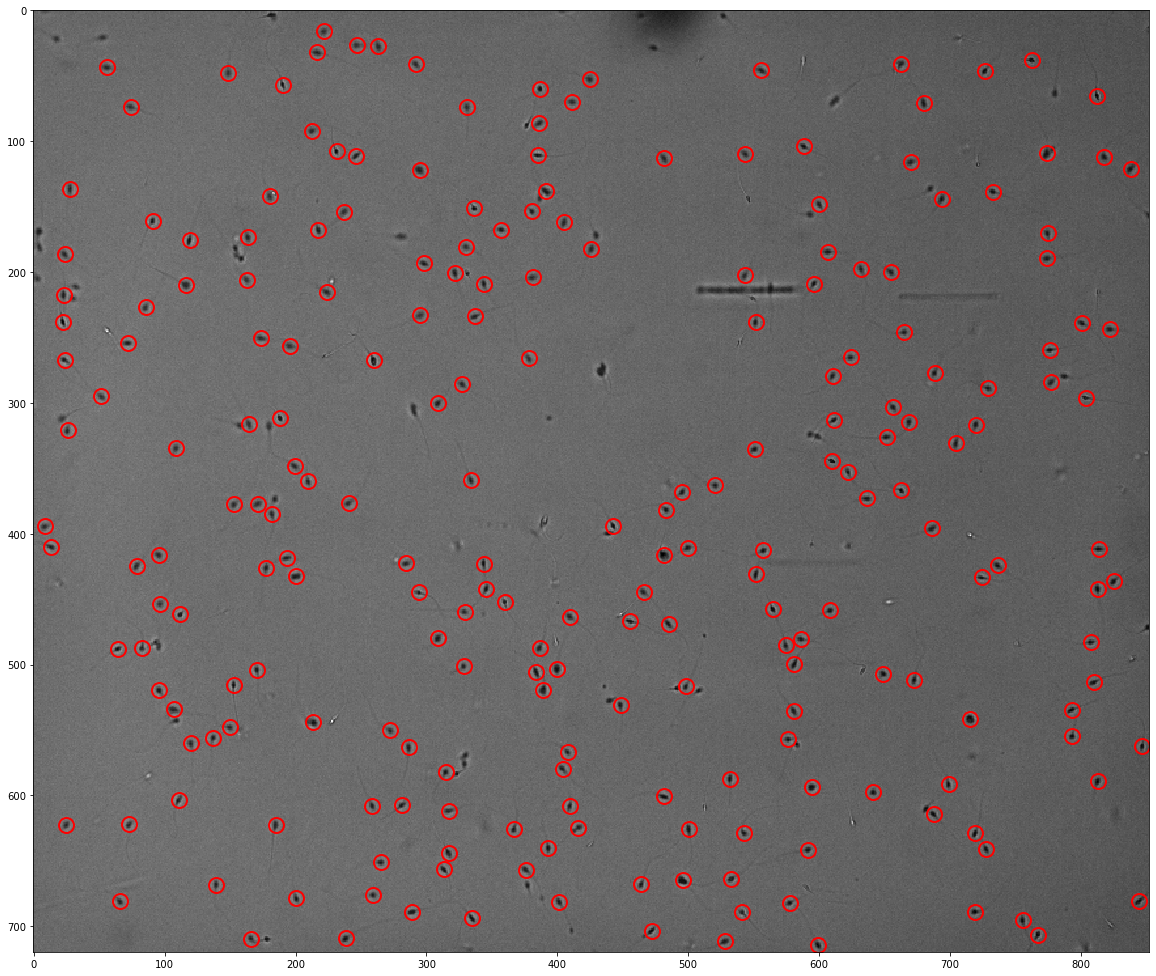

<AxesSubplot:>

In [10]:
plt.figure()
tp.annotate(particles[particles.frame==0], frames[0])

In [11]:
#particle linking with hot fix for sub_net_size problem in some wells
try:
    linked_particles = tp.link_df(particles, search_range = 15, memory = 5)
except:
    #more stringent size filter
    particles = particles[(particles.signal > 950) & (particles['size'] < 2.3)]
    linked_particles = tp.link_df(particles, search_range = 15, memory = 5)

Frame 22: 244 trajectories present.


In [12]:
#track filtering based on 14 frames threshold
filtered_tracks = tp.filter_stubs(linked_particles, threshold = 14)

In [13]:
#save x, y, frame, particleID for kinematic analysis
filtered_tracks.head()

y           x          mass      size       ecc       signal  \
frame                                                                          
0      479.719142  308.773316  22263.502296  1.905434  0.083183  1493.584653   
0      480.243499  586.201977  15442.991984  1.776655  0.263512  1281.152278   
0      482.635748  807.726452  15313.344779  1.861524  0.313669  1261.823348   
0      485.211178  574.671128  15892.708215  2.079028  0.225146  1155.939045   
0      486.949995   82.825748  14329.162393  1.855726  0.152005  1226.935692   

        raw_mass        ep  frame  particle  
frame                                        
0      4983532.0 -0.750599      0         1  
0      4989670.0 -1.452797      0         2  
0      5001302.0  1.879721      0         3  
0      4992829.0 -2.801793      0         4  
0      4960288.0 -0.265195      0         5

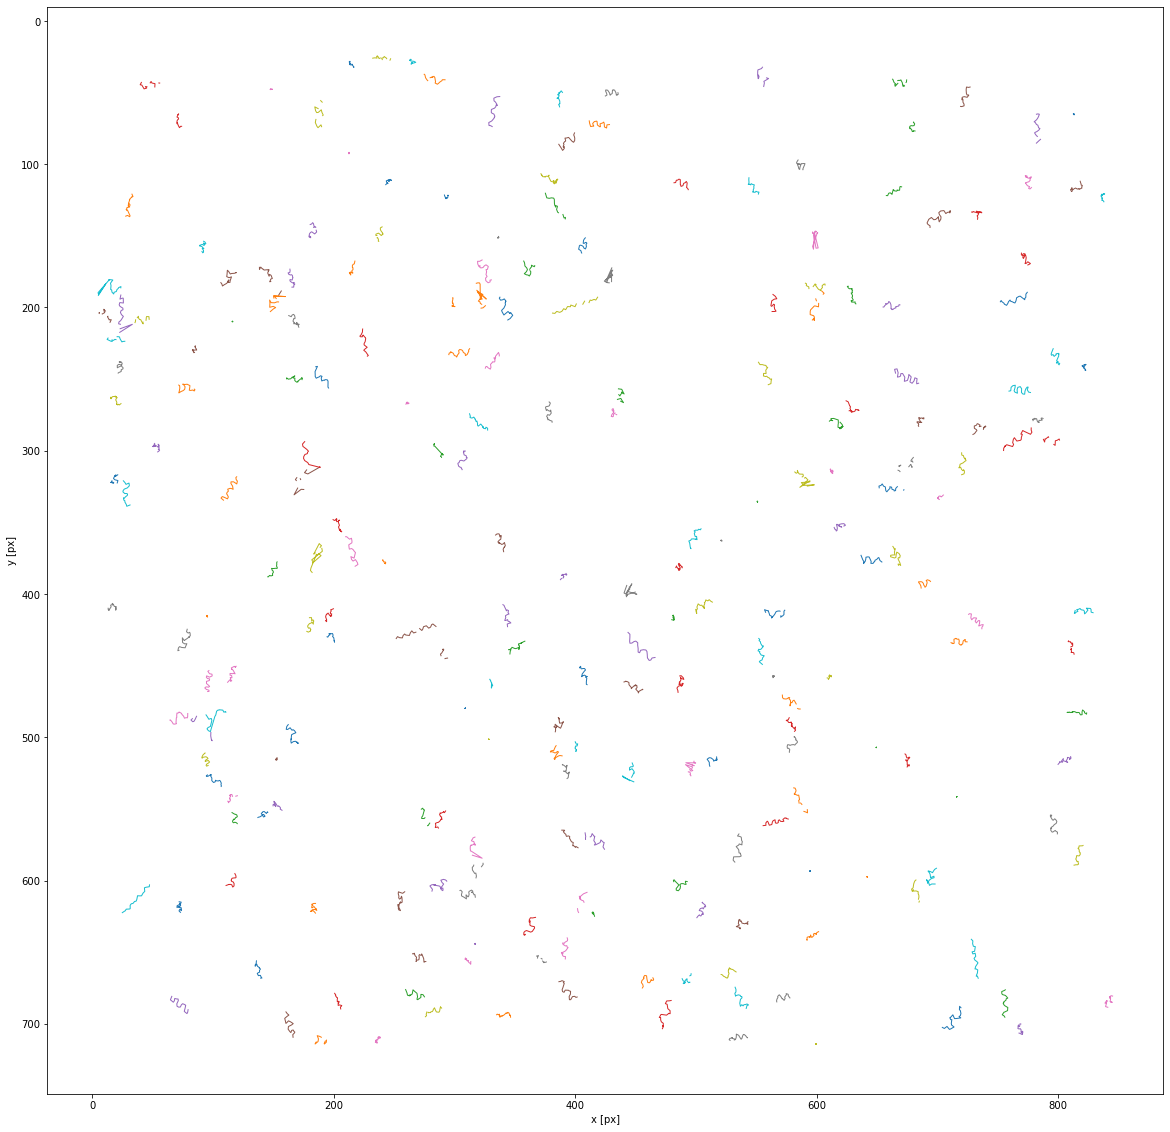

<AxesSubplot:xlabel='x [px]', ylabel='y [px]'>

In [14]:
#inspect tracks
plt.figure()
tp.plot_traj(filtered_tracks)

## Convert the track into OME Rois

* First create an empty data frame to collect the measurement for each point
* Convert each point into an OME point
* Add the point to the ROI and save the ROI
* The identifier of the ROI is then added to the data frame

In [15]:
columns = list(filtered_tracks.columns)
columns.append("ID")  
general_df = pd.DataFrame(columns=columns)

Initialize the service to save the Rois

In [16]:
svc = conn.getUpdateService()

In [22]:
def rgba_to_int(red, green, blue, alpha=255):
    return int.from_bytes([red, green, blue, alpha], byteorder='big', signed=True)

count = filtered_tracks['particle'].nunique()
print(count)
for c in range(0, count):
    track =  filtered_tracks.loc[filtered_tracks['particle'] == c]
    roi = RoiI()
    roi.setImage(image._obj)
    points = ""
    for index, row in track.iterrows():
        t = row['frame']
        point = PointI()
        point.x = rdouble(float(row['x']))
        point.y = rdouble(float(row['y']))
        point.theT = rint(int(row['frame']))
        roi.addShape(point)
        points += "%s,%s " % (str(row['x']), str(row['y']))

    polyline = PolylineI()
    polyline.points = rstring(points)
    polyline.fillColor = rint(rgba_to_int(255, 0, 255, 50))
    polyline.strokeColor = rint(rgba_to_int(255, 255, 0))
    roi.addShape(polyline)
    # Save the roi
    if points:
        roi = svc.saveAndReturnObject(roi)
        # Set the ROI Id in the data frame
        track = track.copy()
        track['RoiID'] = roi.getId().getValue()
        general_df = general_df.copy().append(track, ignore_index = True)
general_df['ImageID'] = image.getId()

234


## Save data frame as CSV and link it to the image 

In [23]:
archive_name = "tracks_image_%s.csv" % image.getId()
general_df.to_csv(path_or_buf=archive_name, index=False)
namespace = "trackpy"
file_ann = conn.createFileAnnfromLocalFile(
    archive_name, mimetype="text/csv", ns=namespace, desc=None)
image.linkAnnotation(file_ann) 

<FileAnnotationWrapper id=153143>

In [25]:
conn.close()